
# Análise de desempenho de estudantes usando KNN e Árvore de decisão 

Autores: Matheus Henrique Nonsiboni, Daniel Fiori Souza, Livia Kouketsu da Silva, Rafael Lançoni Santos. 

Este notebook tem o objetivo de analisar características sociais a respeito de estudantes e prever se desempenho escolar, classificando como aprovados e reprovados.


## Importações


In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore') 


RS = 57


## Carregar os dados que serão utilizados


In [30]:
file = 'student-mat.csv' 
data = pd.read_csv(file, sep=';')
print("Dados carregados:")
print(data.head())

Dados carregados:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]


## Pré-processamento
Filtrar data - classificar notas >=14 como aprovados e <14 como reprovados para G1, G2 e G3. Considerando que o G3 vai ser a classifcação a ser encontrada pelo nosso método.


In [31]:
counts = data['G3'].value_counts()
filtered_data = data[data['G3'].isin(counts.index)]

filtered_data['G3'] = (filtered_data['G3'] >= 14).astype(int)  # 1 = aprovado, 0 = reprovado

filtered_data['G2'] = (filtered_data['G2'] >= 14).astype(int)
filtered_data['G1'] = (filtered_data['G1'] >= 14).astype(int)

# Transformar variáveis categóricas em variáveis numéricas
filtered_data_encoded = pd.get_dummies(filtered_data, drop_first=True)


## MÉTODO DE PREDIÇÃO KNN (K NEAREST NEIGHBORS)


## 1 - Dividindo o conjunto de dados em treino e teste
Selecionar features (X) e target (y). Prever nota final G3 usando todas as outras colunas como features.


In [32]:
X = filtered_data_encoded.drop(columns=['G3'])
y = filtered_data_encoded['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RS)
print("Conjunto de dados dividido em treino e teste.")
print("Tamanho treino:", X_train.shape, " | Tamanho teste:", X_test.shape)

Conjunto de dados dividido em treino e teste.
Tamanho treino: (316, 41)  | Tamanho teste: (79, 41)



## 2 - Treinar o modelo e fazer previsões 
Métodos fit e predict respectivamente usando a distancia euclidiana para vários valores de K.
Estaremos testando a acurácia, fi-score, precisão e recall, usando validação cruzada com blocos de tamanho 50. 

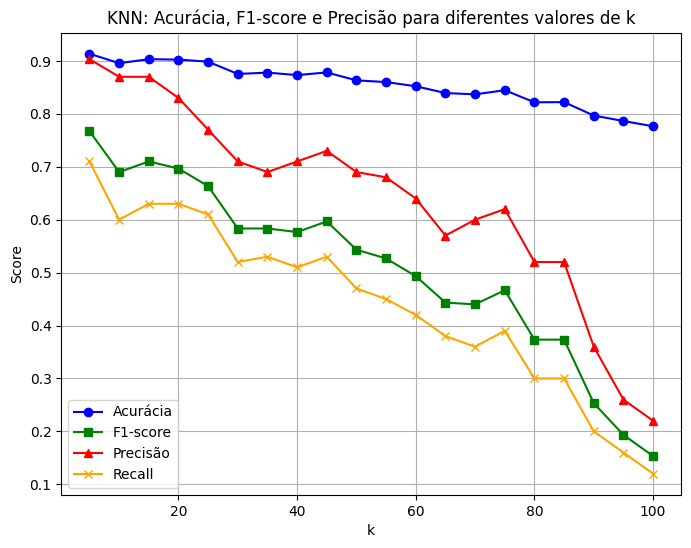

In [33]:
ks = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
accs = []
f1s = []
precisions = []
recall = []
for k in ks:
    knn = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])
    accs.append(cross_val_score(knn, X, y, cv=50, scoring='accuracy').mean()) # Usando validação cruzada com 50 folds
    f1s.append(cross_val_score(knn, X, y, cv=50, scoring='f1').mean())
    precisions.append(cross_val_score(knn, X, y, cv=50, scoring='precision').mean())
    recall.append(cross_val_score(knn, X, y, cv=50, scoring='recall').mean())

plt.figure(figsize=(8, 6))
plt.plot(ks, accs, marker='o', label='Acurácia', color='blue')
plt.plot(ks, f1s, marker='s', label='F1-score', color='green')
plt.plot(ks, precisions, marker='^', label='Precisão', color='red')
plt.plot(ks, recall, marker='x', label='Recall', color='orange')
plt.xlabel('k')
plt.ylabel('Score')
plt.title('KNN: Acurácia, F1-score e Precisão para diferentes valores de k')
plt.legend()
plt.grid(True)
plt.show()



## 3 - Usando agora peso nas distâncias (ponderadas)
Os K mais próximos terão mais efeito sobre a decisão do algoritmo.

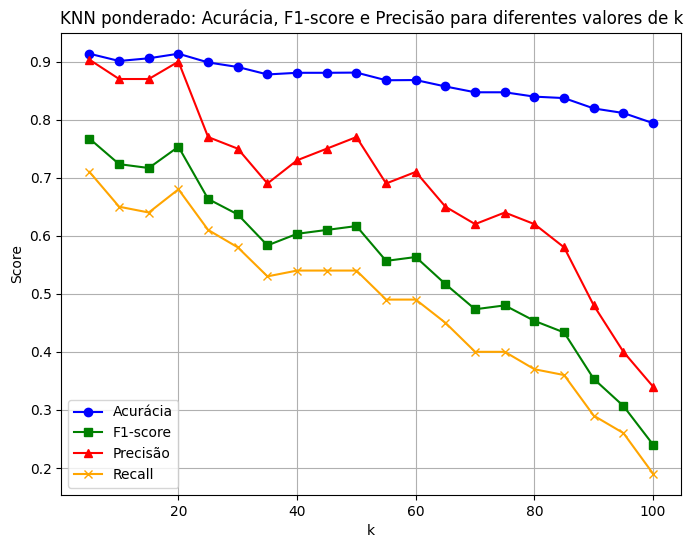

In [34]:
ks = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
accs_distance = []
f1s_distance = []
precisions_distance = []
recalls_distance = []
for k in ks:
    knn_distance = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k, weights='distance'))
    ])
    accs_distance.append(cross_val_score(knn_distance, X, y, cv=50, scoring='accuracy').mean())
    f1s_distance.append(cross_val_score(knn_distance, X, y, cv=50, scoring='f1').mean())
    precisions_distance.append(cross_val_score(knn_distance, X, y, cv=50, scoring='precision').mean())
    recalls_distance.append(cross_val_score(knn_distance, X, y, cv=50, scoring='recall').mean())    

plt.figure(figsize=(8, 6))
plt.plot(ks, accs_distance, marker='o', label='Acurácia', color='blue')
plt.plot(ks, f1s_distance, marker='s', label='F1-score', color='green')
plt.plot(ks, precisions_distance, marker='^', label='Precisão', color='red')
plt.plot(ks, recalls_distance, marker='x', label='Recall', color='orange')
plt.xlabel('k')
plt.ylabel('Score')
plt.title('KNN ponderado: Acurácia, F1-score e Precisão para diferentes valores de k')
plt.legend()
plt.grid(True)
plt.show()


## MÉTODO DE PREDIÇÃO ÁRVORE DE DECISÃO

## 1. Treinamento do modelo DecisionTreeClassifier

Usaremos o critério de **entropia** para as divisões.

In [35]:
# Instanciar o classificador
modelo = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Treinar o modelo
modelo.fit(X_train, y_train)

,criterion,'entropy'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


## 2. Avaliação do Modelo

Vamos calcular a acurácia no conjunto de teste.

In [36]:
# Avaliar o desempenho
acuracia = modelo.score(X_test, y_test)
print(f"Acurácia no conjunto de teste: {acuracia:.2f}")

Acurácia no conjunto de teste: 0.89


## 3. Visualização da Árvore de Decisão

Agora vamos visualizar a estrutura da árvore treinada.

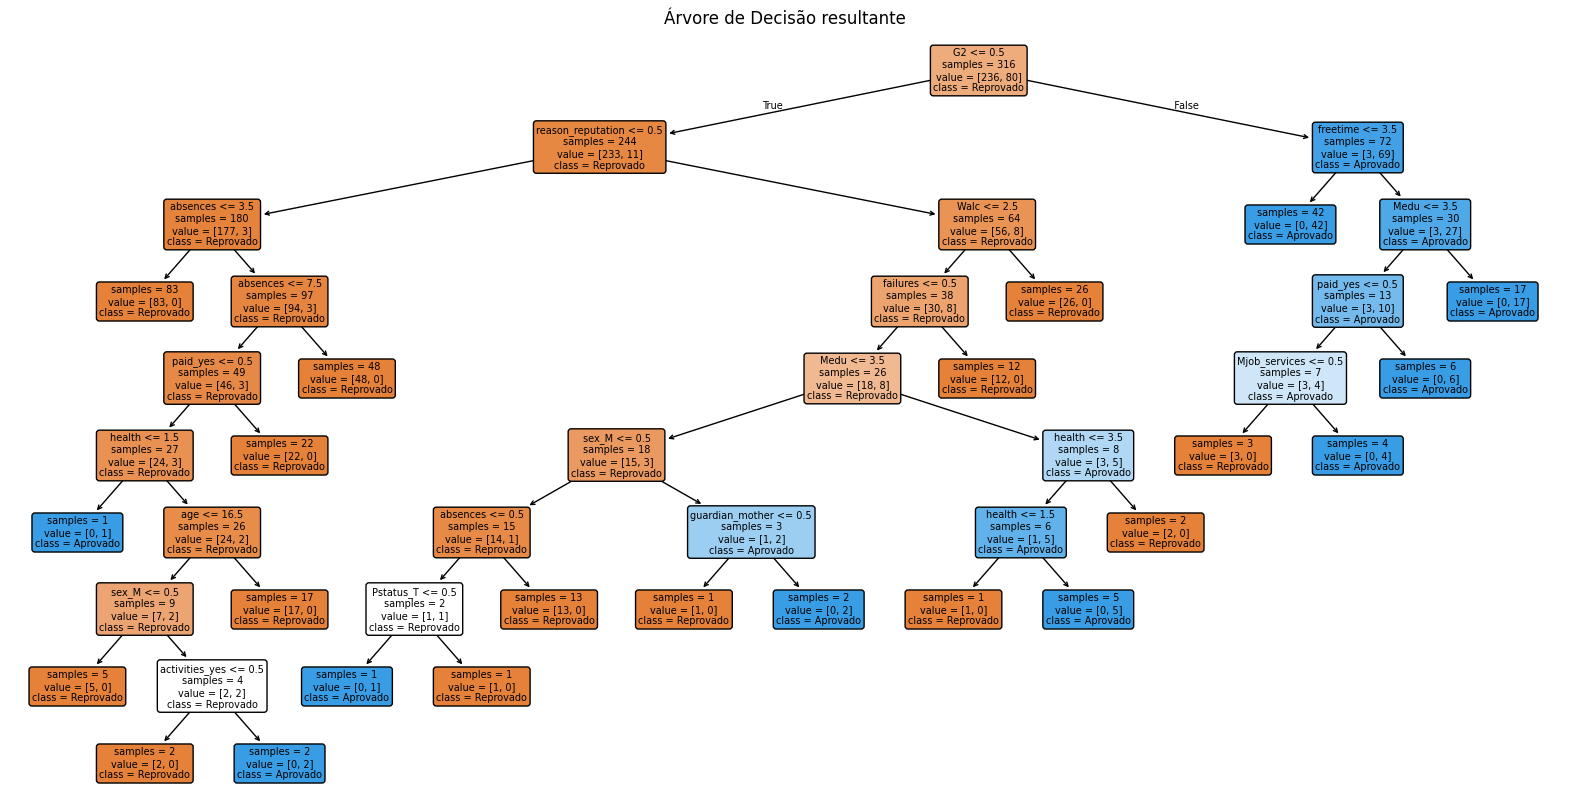

In [37]:
# Plotar a árvore
plt.figure(figsize=(20,10))
plot_tree(modelo, 
          feature_names=filtered_data_encoded.drop('G3', axis=1).columns.tolist(), 
          class_names=['Reprovado', 'Aprovado'], 
          filled=True, 
          rounded=True, 
          impurity=False,
          proportion=False,
          fontsize=7)
plt.title("Árvore de Decisão resultante")
plt.show()

## CURVA ROC E AUC - COMPARAÇÃO DE RESULTADOS
No caso do K-NN fizemos a curva com k = 20, que apresentou os melhores resultados de K

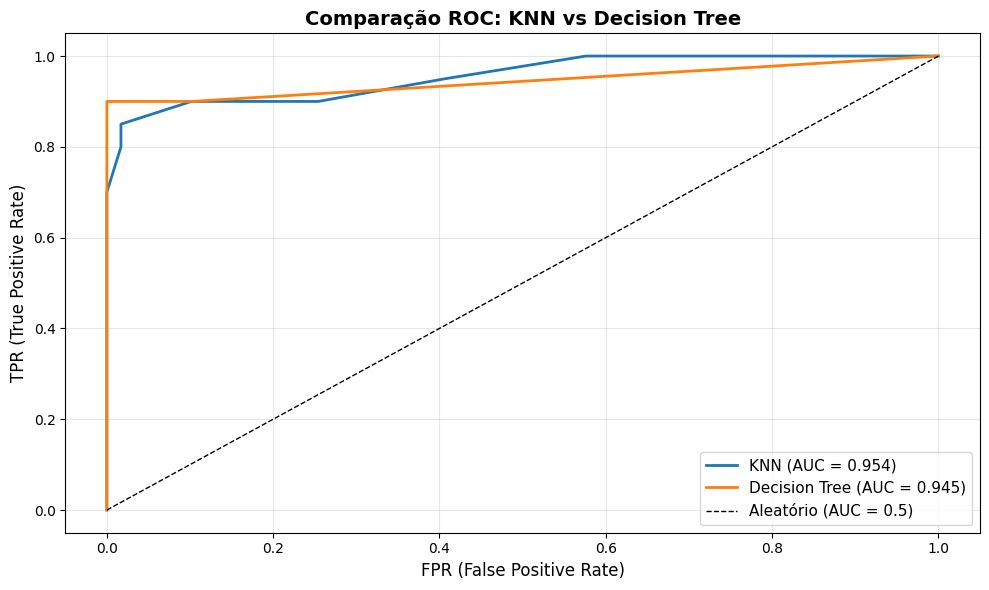

AUC KNN:           0.9542
AUC Decision Tree: 0.9449

KNN é melhor pois o AUC é mais próximos de 1.


In [39]:
# KNN
k = 20  
knn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=k))
])
knn.fit(X_train, y_train)
y_proba_knn = knn.predict_proba(X_test)[:, 1]

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)
auc_knn = roc_auc_score(y_test, y_proba_knn)

# Decision Tree 
modelo = DecisionTreeClassifier(random_state=42, max_depth=5)  # ajuste os parâmetros
modelo.fit(X_train, y_train)
y_proba_dt = modelo.predict_proba(X_test)[:, 1]

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
auc_dt = roc_auc_score(y_test, y_proba_dt)

# PLOT COMPARATIVO
plt.figure(figsize=(10, 6))

# Curva KNN
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.3f})', linewidth=2)

# Curva Decision Tree
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.3f})', linewidth=2)

# Linha aleatória
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.5)', linewidth=1)

plt.xlabel('FPR (False Positive Rate)', fontsize=12)
plt.ylabel('TPR (True Positive Rate)', fontsize=12)
plt.title('Comparação ROC: KNN vs Decision Tree', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# RESULTADOS 
print(f"AUC KNN:           {auc_knn:.4f}")
print(f"AUC Decision Tree: {auc_dt:.4f}")
print(f"\n{'KNN é melhor' if auc_knn > auc_dt else 'Decision Tree é melhor'}" + " pois o AUC é mais próximos de 1.")